**Please note this jupyter notebook is in Julia.**

### Diversity Trumps Ability

&nbsp;

In 2004, Lu Hong and Scott E. Page published a game-changing paper on diversity. They used agent-based model to prove that a diverse group of people is better than a group of best-performing individuals. These days, diversity is a hot topic as it falls into the spectrum of ESG. Don't get me wrong. Diversity here doesn't stand for gender or ethnicity. Diversity refers to the differences in problem solvers' perspectives and heuristics (Hong and Page, 1998). It is the variation in how people encode and search for solutions to problems. Despite the high citations of this paper, plenty of scholars dispute the idea which makes the theory rather controversial. The caveat is the experiment of solving problems on lattice is too simple and straight forward whereas in real life the situation is more dynamic. The diversity theory is completely inapplicable to social science. So the objective here is to convert lattice problem into the context of avant-garde random graphs. This random graph should satisfy two conditions. First, it should have as many of the properties of a real life problem as possible and second it should be simple with respect to our ability to simulate the performance of different agents. Thus, let's run an agent-based simulation on Waxman model.

In [1]:
import Plots
import Random
import LinearAlgebra
import Distributions
import Statistics

### Functions

In [2]:
#create waxman model
#which is a more generalized random geometric graph
#return the adjacency matrix
#the raison d'être of waxman model is
#its similarity with real geographic features
#the connectivity should be negatively correlated with distance
function create_waxman_model(coordinates,α=0.1,β=0.1)

    #create euclidean distance matrix
    distance_matrix=[LinearAlgebra.norm(coordinates[i]-coordinates[j]) for i in eachindex(coordinates),j in eachindex(coordinates)];

    #create adjacency matrix
    adjacency=zeros(length(coordinates),length(coordinates));

    #only connect vertices when the probability is larger than the threshold
    L=maximum(distance_matrix)
    for i in 1:length(coordinates)
        for j in i+1:length(coordinates)
            prob=β*ℯ^(-distance_matrix[i,j]/L*α)
            if Random.rand()>1-prob
                adjacency[i,j]=distance_matrix[i,j]
                adjacency[j,i]=distance_matrix[i,j]
            end
        end
    end
    
    return adjacency,distance_matrix
end

create_waxman_model (generic function with 3 methods)

In [3]:
#draw graph without graphplot.jl
#basically scatter plot to show vertices
#line plot to show edges
function viz(adjacency,coordinates)

    pic=Plots.plot(legend=false,grid=false,axis=false,
        title="Waxman Model"
                )

    #plot edges
    for i in 1:length(coordinates)
        for j in i+1:length(coordinates)
            if adjacency[i,j]!=0
                Plots.plot!([coordinates[i][1],coordinates[j][1]],
                            [coordinates[i][2],coordinates[j][2]],color="grey")
            end
        end
    end

    #plot vertices
    for i in 1:length(coordinates)
        Plots.scatter!([i[1] for i in coordinates],
            [i[2] for i in coordinates],
            markersize=10)
    end

    pic
    
end

viz (generic function with 1 method)

In [4]:
#agent based modelling
function agent_based_simulation(subgroup,adjacency,distance_matrix,
        agents,max_path=100,current_vertex=1)

    path=[]
    stop=false
    while !stop
        for agent_id in subgroup       

            #create agent perspective+heuristic
            d=Distributions.Normal(agents[agent_id]["perspective"],
                agents[agent_id]["heuristic"],)
            td=Distributions.truncated(d,-Inf,Inf)

            #find neighbors of current vertex and their distance to the terminal
            neighbors_key=[i for i in eachindex(adjacency[current_vertex,:]) if adjacency[current_vertex,i]!=0]
            neighbors_val=[distance_matrix[i,length(adjacency[1,:])] for i in eachindex(adjacency[current_vertex,:]) if adjacency[current_vertex,i]!=0]
            neighbors=Dict(zip(neighbors_key,neighbors_val))

            #update the distance with perspective+heuristic
            #the way it works is similar to a* algorithm in graph theory
            # https://github.com/je-suis-tm/graph-theory/blob/master/a_star%20maze.ipynb
            for neighbor_id in keys(neighbors)    
                ϵ=Random.rand(td)
                neighbors[neighbor_id]+=ϵ
            end

            #select next vertex based upon the shortest subjective distance to the terminal
            push!(path,current_vertex)
            selected_neighbor=sort(collect(neighbors),by=x->x[2])[1][1]
            current_vertex=selected_neighbor                                 

            #when maximum path length is reached
            #terminate the while loop
            if length(path)==max_path
                stop=true
                push!(path,current_vertex)              
                break
            end

            #when destination is reached
            #terminate the while loop
            if current_vertex==length(adjacency[1,:])
                stop=true
                push!(path,current_vertex) 
                break                    
            end
        end       
    end    
    return path                        
end        

agent_based_simulation (generic function with 3 methods)

In [5]:
#create animated path
function animation(coordinates,vertex_status,filename)

    anim=Plots.@animate for ind in 0:length(path)-1
        pic=Plots.plot(legend=false,grid=false,axis=false,
                title="$filename\nt=$ind")

        #create edges
        for i in 1:length(coordinates)
            for j in i+1:length(coordinates)
                if adjacency[i,j]!=0
                    Plots.plot!([coordinates[i][1],coordinates[j][1]],
                                [coordinates[i][2],coordinates[j][2]],
                                color="grey")
                end
            end
        end

        #create vertices
        #path is showed via different colors
        for i in 1:length(coordinates)
            Plots.scatter!([i[1] for i in coordinates],
                [i[2] for i in coordinates],
                markersize=10,color=[i for i in vertex_status[ind+1]])
        end   
        pic    
    end
    Plots.gif(anim,filename*".gif",fps=0.5)
end

animation (generic function with 1 method)

### Waxman Model Demo

&nbsp;

Waxman model was created by Bernard M. Waxman to test how the algorithms of minimum spanning tree perform on random graphs. The model per se is a reflection of the reality where connectivity is negatively correlated with distance. The probability of creating an edge between vertex $u$ and $v$ is written below.

$$P({u,v})=\beta \times \mathrm{exp} (\frac {-d(u,v)}{L \alpha})$$

where

$P({u,v})$ denotes the probability of creating an undirected edge from vertex $u$ to $v$

$d(u,v)$ denotes Euclidean distance from vertex $u$ to $v$.

$L$ denotes the largest distance inside the rectangular coordinate grid.

$\mathrm{exp}$ denotes Euler's number.

$\alpha$ denotes the density of short edges relative to longer ones.

$\beta$ denotes overall graph edge density.

There are something interesting about Waxman model. $\frac {d(u,v)} {L}$ creates a relative ratio to assess the distance within the rectangular coordinate grid regardless of the actual scale. A smaller $\alpha$ implies more short edges than long edges. A larger $\beta$ indicates more edges take place in general.

In [6]:
#initialize graph order
graph_order=48

#create random coordinates
coordinate_range=20:80
X=Random.rand(coordinate_range,graph_order)
Y=Random.rand(coordinate_range,graph_order)
coordinates=Any[Int32[X[i],Y[i]] for i in 1:length(X)]

#add start and end
startpoint=Int32[1,1]
endpoint=Int32[100,100]
insert!(coordinates,1,startpoint)
insert!(coordinates,length(coordinates)+1,endpoint);

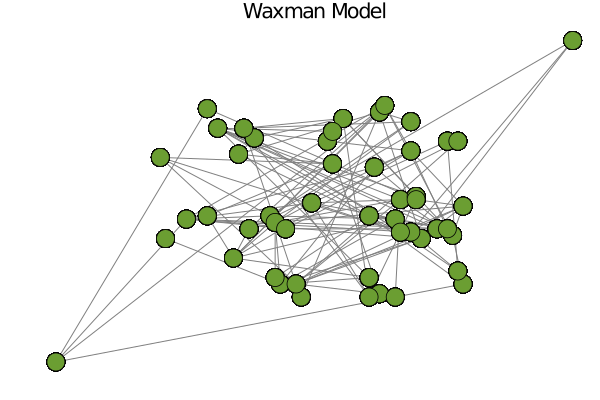

In [7]:
#create waxman model and viz
adjacency,distance_matrix=create_waxman_model(coordinates,0.5,0.1)
viz(adjacency,coordinates)

### Agent-based Model Demo

&nbsp;

In the original paper (Hong and Page, 2004), the authors proposed an agent-based model for a group of agents to find the largest possible value on a lattice. Here, we slightly modify the problem. A group formed with $N$ number of agents are required to travel from $start$ to $end$ on a random graph called Waxman model. Agents collaborate in a group sequentially. At each unit time $t$, agent $i$ pick the next vertex $v$ based upon its perception of the distance from current vertex $u$ to the destination $end$ which is called $f_i(u,end)$. The perception consists of two components, the actual Euclidean distance $d(u,end)$ and random disturbance $\epsilon$. 

$$ f_i(u,end)=d(u,end)+\epsilon_{i}$$

Each agent's $\epsilon$ follows Gaussian distribution with mean $\mu$ and $\sigma$. Because the probability of connecting two vertices $P({u,v})$ is negatively correlated with their Euclidean distance $d(u,v)$, a good instinct for agent is to select a vertex closer to the destination which creates a higher chance of connecting to $end$. In that sense, a good agent should have relatively small $\epsilon$ so its perception of the distance $f_i(u,v)$ is closer to Euclidean distance $d(u,v)$. 

$$\epsilon_{i} \sim \mathcal{N} (\mu_i,\sigma_i)$$

$\mu$ refers to the agent's perspective and $\sigma$ refers to the agent's heuristic. Both $\mu$ and $\sigma$ follow uniform distribution. $\sigma$ has one-sided interval due to its non-negativity constraint. An agent's perspective reflects how the world is perceived by the agent which is fixed by $\mu_i$. A good agent should have $\mu_i$ closer to zero which reflects its objectivity. An agent's heuristic reflects how consistent the agent's perspective is. A good agent should have $\sigma_i$ closer to zero which reflects its subjectivity.

$$\mu_i \sim U [-5,5]$$
$$\sigma_i \sim U [1,5]$$


In [8]:
num_of_agents=50
group_size=5

#create random agents
#their perspectives follow uniform distribution [-5,5]
#their heuristics follow uniform distribution [1,5]
agents=Dict()
for i in 1:num_of_agents 
    agents[i]=Dict()
    agents[i]["perspective"]=Random.rand(-5:5)
    agents[i]["heuristic"]=Random.rand(1:5)
end

In [8]:
#create a random group of size 3
randomgroup=Random.randperm(num_of_agents)[1:group_size]

#create path based upon group selection
path=agent_based_simulation(randomgroup,adjacency,distance_matrix,agents)

8-element Array{Any,1}:
  1
 40
 29
 43
 49
 43
 23
 50

In [10]:
#agent status determines which agent is making vertex selection at time t
agent_status=append!(repeat([i for i in 1:group_size],length(path)÷group_size),
    [i for i in 1:group_size][1:length(path)%group_size])

#vertex status determines which vertex is being occupied by which agent
#this will be used as vertex color mapping for visualization
vertex_status=[]
push!(vertex_status,[4 for _ in 1:length(coordinates)])
vertex_status[end][1]=1
for itr in 1:length(path)-1    
    push!(vertex_status,[i for i in vertex_status[end]])    
    vertex_status[end][path[itr+1]]=agent_status[itr]    
end

┌ Info: Saved animation to 
│   fn = C:\Users\T.M.\Diversity Trumps Ability.gif
└ @ Plots C:\Users\T.M.\.julia\packages\Plots\Xnzc7\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\T.M.\\Diversity Trumps Ability.gif")
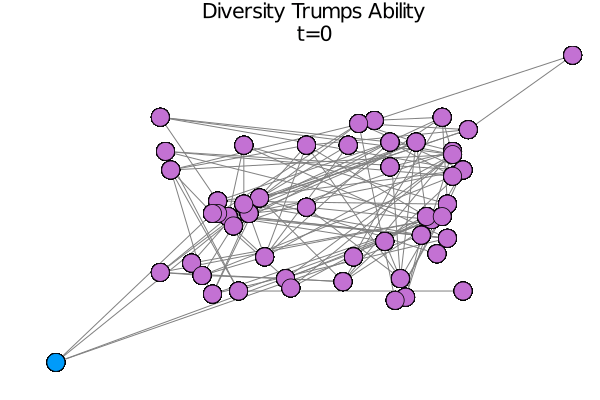

In [11]:
#create animation with simple demo
#different colors show the choices by different agents
filename="Diversity Trumps Ability"
animation(coordinates,vertex_status,filename)

### Diversity and Ability

&nbsp;

The previous one was a simplified demonstration. To replicate the experiment in the paper, we need to expand the order and the size of our random graph. We create a random group which draws agents randomly from the pool to form the democracy. We also create an elite group which draws agents on the top percentile to form the technocracy. For comparison, we examine the mean distance two groups have traveled, the mean length of the paths and the diversity of two groups. The diversity is measured by $\rho$, which is defined by the aggregation of an agent's perspective and heuristic. The diversity metric $\Delta$ is merely the variance of $\rho$ inside the group.

$$ \rho_i=|\mu_i|+\sigma_i$$
$$ \Delta =\frac {1}{N} \sum_{i=1}^{N} (\rho_i-\bar\rho)^2$$ 

In [12]:
#initialize graph order
graph_order=998

#create random coordinates
coordinate_range=3000:7000
X=Random.rand(coordinate_range,graph_order)
Y=Random.rand(coordinate_range,graph_order)
coordinates=Any[Int32[X[i],Y[i]] for i in 1:length(X)]

#add start and end
startpoint=Int32[1,1]
endpoint=Int32[10000,10000]
insert!(coordinates,1,startpoint)
insert!(coordinates,length(coordinates)+1,endpoint);

#create waxman model
adjacency,distance_matrix=create_waxman_model(coordinates,0.2,0.2);

In [13]:
#we should limit the group size
#as the group size grows
#the diversity of elite group converges towards random group
num_of_agents=500
group_size=10

#create random agents
#their perspectives follow uniform distribution [-500,500]
#their heuristics follow uniform distribution [1,500]
agents=Dict()
for i in 1:num_of_agents 
    agents[i]=Dict()
    agents[i]["perspective"]=Random.rand(-500:500)
    agents[i]["heuristic"]=Random.rand(1:500)
end

In [14]:
#a fine balance between speed and effectiveness
num_of_simulations=500;

In [15]:
#agent based simulation of random group
distance_arr=[]
path_arr=[]
subgroup_diversity_arr=[]
for _ in 1:num_of_simulations
    subgroup=Random.randperm(num_of_agents)[1:group_size]
    path=agent_based_simulation(subgroup,adjacency,distance_matrix,agents)
    distance=sum([distance_matrix[path[i],path[i+1]] for i in 1:(length(path)-1)])
    subgroup_diversity=Statistics.var([abs(agents[agent_id]["perspective"])+agents[agent_id]["heuristic"] for agent_id in subgroup])
    push!(distance_arr,distance)
    push!(path_arr,length(path))
    push!(subgroup_diversity_arr,subgroup_diversity)    
end    
println("Distance travelled:",Statistics.mean(distance_arr))
println("Length of the path:",Statistics.mean(path_arr))
println("Group diversity:",Statistics.mean(subgroup_diversity_arr))

Distance travelled:26941.876843500664
Length of the path:41.862
Group diversity:41342.13211111111


In [16]:
#random group quickly finds the path
#even though sometimes it looks like a random walk
path

47-element Array{Any,1}:
    1
  339
  188
  339
    2
  339
  940
  339
    2
  717
  704
  458
  956
    ⋮
  458
  864
  458
  466
  458
  466
  458
  704
  717
  839
  587
 1000

In [17]:
#agent based simulation of elite group
distance_arr=[]
path_arr=[]
elitegroup_diversity_arr=[]
elitegroup=[i[1] for i in (sort(collect(agents),by=x->abs(x[2]["perspective"])+x[2]["heuristic"])[1:group_size])]
for _ in 1:num_of_simulations
    path=agent_based_simulation(elitegroup,adjacency,distance_matrix,agents)
    distance=sum([distance_matrix[path[i],path[i+1]] for i in 1:(length(path)-1)])
    elitegroup_diversity=Statistics.var([abs(agents[agent_id]["perspective"])+agents[agent_id]["heuristic"] for agent_id in elitegroup])
    push!(distance_arr,distance)
    push!(path_arr,length(path))
    push!(elitegroup_diversity_arr,elitegroup_diversity)    
end    
println("Distance travelled:",Statistics.mean(distance_arr))
println("Length of the path:",Statistics.mean(path_arr))
println("Group diversity:",Statistics.mean(elitegroup_diversity_arr))

Distance travelled:37314.666960949704
Length of the path:88.468
Group diversity:888.9000000000071


In [18]:
#apparently the elite group suffers from elite bias
#an elite agent has firm heuristic which makes it not very open to other options
#thus elite group spends a lot of time back and forth making no progress at all
path

42-element Array{Any,1}:
    1
  339
  188
  339
  188
  339
  188
  339
  188
  339
  188
  339
  188
    ⋮
  188
  339
  188
  339
  188
  339
  188
  339
  188
  339
  661
 1000

### Discussion

&nbsp;

I was quite a bit shocked to learn that diversity trumps ability in this experiment! This is no cherry picking. If you run enough times of simulations, you will see the random group beats the elite group for most of the times.

The problem with the technocracy is elite bias. As we have observed from the example, an elite has relatively objective perspective and fairly stable heuristic which is good for a deterministic problem. When facing a stochastic problem with random twists and turns, an elite agent's may not be very open to other available options. Now how do we tackle the bias issue? **Diversity!** Elites think alike. A democratic representation of the agents is no panacea but it cancels out the random noise caused by each agent's own perspective and heuristic. In short, **diversity trumps ability!**

### Further Reading

&nbsp;

1. Hong L, Page SE (1998)

	Diversity And Optimality

	https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.80.8046&rep=rep1&type=pdf

	*This paper gives a clear definition of diversity and its relationship with local optima.*
    
&nbsp;
2. Hong L, Page SE (2004)

	Groups Of Diverse Problem Solvers Can Outperform Groups Of High-ability Problem Solvers

	https://www.pnas.org/content/101/46/16385

	*One of the most influential papers on diversity. Our experiment is based upon this paper.*
    
&nbsp;
3. Hong L, Page SE (2001)

	Problem Solving By Heterogenous Agents

	https://sites.lsa.umich.edu/scottepage/wp-content/uploads/sites/344/2015/11/jet.pdf

	*This paper illustrates the application of diverse problem solving agents in the public funding problems*
    
&nbsp;
4. Hong L, Page SE (2012)

	Some Microfoundations Of Collective Wisdom

	http://sites.lsa.umich.edu/wp-content/uploads/sites/344/2015/11/CollectWisdomParissubmitted.pdf

	*This paper proves the diversity prediction theorem from the perspective of statistics. The greater the diversity, the better the prediction*
    
&nbsp;
5. Houlou-Garcia A (2017)

	Collective Wisdom, Diversity And Misuse Of Mathematics

	https://www.cairn-int.info/publications-of-Houlou-Garcia-Antoine--66972.htm

	*This paper argues the experiment done by Hong and Page in 2004 is inapplicable to political science. The experiment made a poor mathematical inference.*
    
&nbsp;
6. Thompson A (2014)

	Does Diversity Trump Ability?

	https://www.ams.org/notices/201409/rnoti-p1024.pdf

	*The author provides counter-example to challenge the computational experiment done by Hong and Page in 2004. The attempt to equate mathematical quantities with human attributes is inappropriate.*